<a href="https://colab.research.google.com/github/thamizhannal/eva5/blob/master/EVA4Session2_v3_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### EVA4: Session4 Assignment

Refer to this code: COLABLINK https://colab.research.google.com/drive/1uJZvJdi5VprOQHROtJIHy0mnY2afjNlx <br>
WRITE IT AGAIN SUCH THAT IT ACHIEVES <br> 
*  99.4% validation accuracy <br>
*  Less than 20k Parameters <br>
*  You can use anything from above you want.  <br>
*  Less than 20 Epochs <br>
*  No fully connected layer <br>
*  To learn how to add different things we covered in this session, you can refer to this code: https://www.kaggle.com/enwei26/mnist-digits-pytorch-cnn-99 DONT COPY ARCHITECTURE, JUST LEARN HOW TO INTEGRATE THINGS LIKE DROPOUT, BATCHNORM, ETC. <br>




#### **DNN Approch & Architecture:**
**Input DataSet:** MNIST dataset is consist of human hand written monochrome images of size 28x28. Our objective is to detect human hand written digits using simple DNN. 

**Network Architecture:**
We chosen to experiment squeeze & expansion arcitecture to detect numbers in MINIST dataset. This architecute consist of convolution blocks followed by transition blocks. 

**Convolution Block:**
In convolution block, we use convolution layers that consist of kernels of size in incremental order e.g 8, 16, 20.  

**Transition Block:**
In transition block, we reduced num of kernel size to 8 from 20. 
After convolution block, we applied 1x1 convolution in trasition block that helped us to reduce num of kernels. This is squeeze operation. 


**Edges and Gradients:** Since input images are small in size, our network can expected extract edges and gradients at the Receptive Fields of 5-7. It is required to have 2-3 convolution layers to detect edges & graidents

**Max Pooling:** It filters out least importenet features and sends out most importent features to consecutive layers for prediction.

**1x1 convolution** 

**BatchNormalization**
We applied batch normalization after every convolution(cond2d()). BN helped us to standardize the input to a convloution layer for every mini-batch. This stablizes the learning process and also accelerates the DNN training.

**AvgPooling**
We applied AvgPooling in before prediction that calculates the average value for each pixel on the feature map.

**Early Stopping**
If validation accuracy is not improving for more than 10 epoch we stopped trainings

**Train Vs Validation Plot**
We captured train loss, train accuracy, validation loss & validation accuracies for all epochs and plotted a) train vs validation loss plot and b) train vs validation loss plots. These helps us to figure out gap between train vs validation loss & accuracies.






In [36]:
from __future__ import print_function
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [37]:
!pip install torchsummary
from torchsummary import summary


In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution Block-1 ###################################
        # Input:28x28  Outout:26x26 RF:3x3
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=8, kernel_size=3, padding=0) 
        self.bn1 = nn.BatchNorm2d(8)
        
        # Input:26x26  Outout:24x24 RF:5x5
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels=16, kernel_size=3, padding=0) 
        self.bn2 = nn.BatchNorm2d(16)

        # Input:24x24  Outout:22x22 RF:7x7
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels=20, kernel_size=3, padding=0) 
        self.bn3 = nn.BatchNorm2d(20)
        
        # Transition Block-1 #######################################
        # Input:22x22  Outout:11x11 RF:14x14
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # Input:11x11  Outout:11x11 RF:14x14
        self.conv4 = nn.Conv2d(in_channels = 20, out_channels=8, kernel_size=1, padding=0)
        self.bn4 = nn.BatchNorm2d(8)
        
        # Convolution Block-2 #########################################
        # Input:11x11  Outout:9x9 RF:16x16
        self.conv5 = nn.Conv2d(in_channels = 8, out_channels=16, kernel_size=3, padding=0)
        self.bn5 = nn.BatchNorm2d(16)
        
        # Input:9x9  Outout:7x7 RF:18x18
        self.conv6 = nn.Conv2d(in_channels = 16, out_channels=20, kernel_size=3, padding=0) # nn.Conv2d(in_channels=24, out_channels=16, kernel_size=1, padding=1)
        self.bn6 = nn.BatchNorm2d(20)
        
        # Transition Block-2 #############################################
        # Input: 7x7  Outout:3x3 RF:18x18
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        # Final Prediction
        # Input:9x9  Outout:1x1 RF:21x21
        self.conv7 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.bn3(self.conv3(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))))))
        x = self.pool2(F.relu(self.bn6(self.conv6(F.relu(F.relu(self.bn5(self.conv5(F.relu(self.bn4(self.conv4(x)))))))))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [39]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 16, 24, 24]           1,168
       BatchNorm2d-4           [-1, 16, 24, 24]              32
            Conv2d-5           [-1, 20, 22, 22]           2,900
       BatchNorm2d-6           [-1, 20, 22, 22]              40
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8            [-1, 8, 11, 11]             168
       BatchNorm2d-9            [-1, 8, 11, 11]              16
           Conv2d-10             [-1, 16, 9, 9]           1,168
      BatchNorm2d-11             [-1, 16, 9, 9]              32
           Conv2d-12             [-1, 20, 7, 7]           2,900
      BatchNorm2d-13             [-1, 20, 7, 7]              40
        AvgPool2d-14             [-1, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:

torch.manual_seed(1)
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [41]:
from tqdm import tqdm
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    train_correct = 0
    train_acc = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        train_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    print('\nTrain Set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
       
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    val_acc = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accuracy.append(val_acc)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [42]:
import time
import copy 
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# We train DNN for 20 epochs, here value 21 is exclusive. 
for epoch in range(1, 21):
    print("\nepoch:{}".format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

    # Early Stop, if validation accuracy does not improves.
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_weights)
            break    
    

    
        

  0%|          | 0/1875 [00:00<?, ?it/s]


epoch:1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 1875/1875 [00:18<00:00, 99.83it/s] 


Train Set: Average loss: 0.1162, Accuracy: 58018/60000 (96.70%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9871/10000 (98.71%)

epoch:2


100%|██████████| 1875/1875 [00:18<00:00, 99.25it/s]


Train Set: Average loss: 0.0439, Accuracy: 59206/60000 (98.68%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9874/10000 (98.74%)

epoch:3


100%|██████████| 1875/1875 [00:18<00:00, 100.22it/s]


Train Set: Average loss: 0.0346, Accuracy: 59357/60000 (98.93%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9913/10000 (99.13%)

epoch:4


100%|██████████| 1875/1875 [00:18<00:00, 99.58it/s] 


Train Set: Average loss: 0.0288, Accuracy: 59453/60000 (99.09%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

epoch:5


100%|██████████| 1875/1875 [00:19<00:00, 98.12it/s]


Train Set: Average loss: 0.0256, Accuracy: 59525/60000 (99.21%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)
Validation loss has not improved since: 0.022.. Count:  1

epoch:6


100%|██████████| 1875/1875 [00:19<00:00, 98.64it/s] 


Train Set: Average loss: 0.0233, Accuracy: 59563/60000 (99.27%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9913/10000 (99.13%)
Validation loss has not improved since: 0.022.. Count:  2

epoch:7


100%|██████████| 1875/1875 [00:18<00:00, 99.20it/s]


Train Set: Average loss: 0.0209, Accuracy: 59612/60000 (99.35%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)
Validation loss has not improved since: 0.022.. Count:  3

epoch:8


100%|██████████| 1875/1875 [00:18<00:00, 99.82it/s] 


Train Set: Average loss: 0.0187, Accuracy: 59657/60000 (99.43%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)
Validation loss has not improved since: 0.022.. Count:  4

epoch:9


100%|██████████| 1875/1875 [00:18<00:00, 100.33it/s]


Train Set: Average loss: 0.0169, Accuracy: 59658/60000 (99.43%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

epoch:10


100%|██████████| 1875/1875 [00:18<00:00, 100.63it/s]


Train Set: Average loss: 0.0160, Accuracy: 59691/60000 (99.48%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

epoch:11


100%|██████████| 1875/1875 [00:18<00:00, 101.04it/s]


Train Set: Average loss: 0.0138, Accuracy: 59753/60000 (99.59%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9949/10000 (99.49%)

epoch:12


100%|██████████| 1875/1875 [00:18<00:00, 101.43it/s]


Train Set: Average loss: 0.0140, Accuracy: 59737/60000 (99.56%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)
Validation loss has not improved since: 0.019.. Count:  1

epoch:13


100%|██████████| 1875/1875 [00:18<00:00, 101.94it/s]


Train Set: Average loss: 0.0120, Accuracy: 59789/60000 (99.65%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9913/10000 (99.13%)
Validation loss has not improved since: 0.019.. Count:  2

epoch:14


100%|██████████| 1875/1875 [00:18<00:00, 102.30it/s]


Train Set: Average loss: 0.0111, Accuracy: 59790/60000 (99.65%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9933/10000 (99.33%)
Validation loss has not improved since: 0.019.. Count:  3

epoch:15


100%|██████████| 1875/1875 [00:18<00:00, 102.04it/s]


Train Set: Average loss: 0.0109, Accuracy: 59800/60000 (99.67%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9941/10000 (99.41%)
Validation loss has not improved since: 0.019.. Count:  4

epoch:16


100%|██████████| 1875/1875 [00:18<00:00, 102.51it/s]


Train Set: Average loss: 0.0093, Accuracy: 59814/60000 (99.69%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)
Validation loss has not improved since: 0.019.. Count:  5

epoch:17


100%|██████████| 1875/1875 [00:18<00:00, 101.48it/s]


Train Set: Average loss: 0.0098, Accuracy: 59813/60000 (99.69%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)
Validation loss has not improved since: 0.019.. Count:  6

epoch:18


100%|██████████| 1875/1875 [00:18<00:00, 102.14it/s]


Train Set: Average loss: 0.0091, Accuracy: 59810/60000 (99.68%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)
Validation loss has not improved since: 0.019.. Count:  7

epoch:19


100%|██████████| 1875/1875 [00:18<00:00, 100.86it/s]


Train Set: Average loss: 0.0081, Accuracy: 59846/60000 (99.74%)



  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)
Validation loss has not improved since: 0.019.. Count:  8

epoch:20


100%|██████████| 1875/1875 [00:18<00:00, 101.24it/s]


Train Set: Average loss: 0.0075, Accuracy: 59868/60000 (99.78%)



Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)
Validation loss has not improved since: 0.019.. Count:  9


### Early Stopping ###

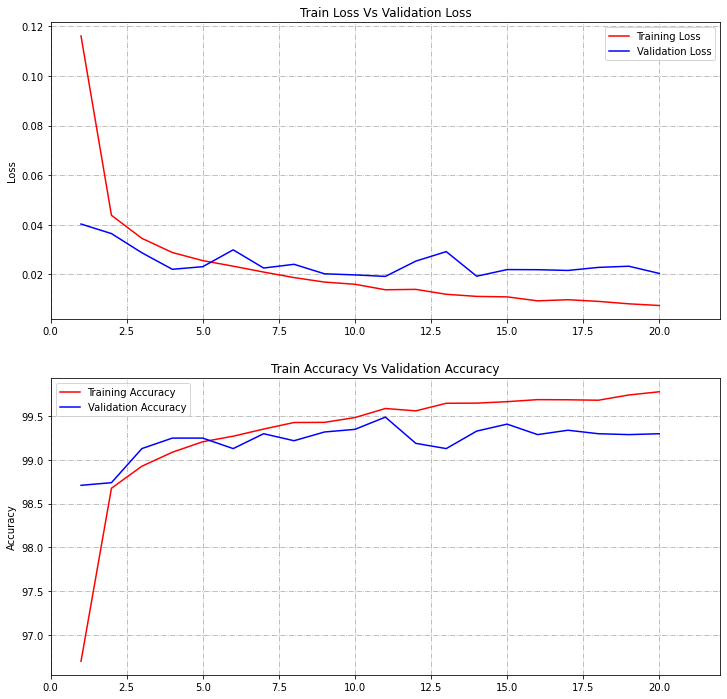

In [46]:
import matplotlib.pyplot as plt
epoch = 20
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Loss')
plt.title('Train Loss Vs Validation Loss')
plt.plot(range(1, epoch+1), train_losses[:epoch+1], 'r', label='Training Loss')
plt.plot(range(1, epoch+1), val_losses[:epoch+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)

ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Accuracy')
plt.title('Train Accuracy Vs Validation Accuracy')
plt.plot(range(1, epoch+1), train_accuracy[:epoch+1], 'r', label='Training Accuracy')
plt.plot(range(1, epoch+1), val_accuracy[:epoch+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

### **Conclusion:** ###
I have implemented a simple convolution neural network architecture, that consist of two convolution and transition blocks (CT) with default batch size=32, epoch=20 and optimizer=SGD. 

**First convolution Block:** Consist of 3 convolution layers of channel size 8, 16 & 20
**First Transition Block:** Consist of Max Pooling layer of 2x2 followed by 1x1 convolution of 8 channels. Here we reduced channels size from 20 to 8.

**Second Convolution Block:** Consist of 2 convolution layers of channel size 16 & 20

**Second Transition Block:** Consist of AveragePooling.

**Final Prediction:** Final convolution layer reduced channel size from 20 to 10 with 3x3 kernel and predicted digits. 

### **Output:** ###
We trained DNN for 20 epoch and reched highest validation accuracy as 99.49% at 11th epoch.

**Train Vs validation accuracy plot:** It is evident that small gap between train & validation accuracies from 1st to 11th epochs, that means model learns better, after that gap between train vs validation increases that seems model is not learning much and we have to add additional methods to make it better.

**Train Vs validation loss plot:**
From 1st to 11th epoch train loss is start reducing drastially and gradually. There was less gap between train vs validation loss means that **model is not overfitting, ** after 11th epoch loss between train vs validation start increasing. So, it is better to stop at 11th epoch after which model does not improve much or we have to try additional apporaches to improve this model.
